In [1]:
import numpy as np
import pandas as pd
from processing_functions import *
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_colwidth', None)  # Show full strings in columns
des = pd.read_csv("data/raw/HomeCredit_columns_description.csv", encoding="latin1", usecols=[1,2,3,4])
des = des[des.Table!='application_{train|test}.csv']
des.Table.unique()

/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


array(['bureau.csv', 'bureau_balance.csv', 'POS_CASH_balance.csv',
       'credit_card_balance.csv', 'previous_application.csv',
       'installments_payments.csv'], dtype=object)

# Introduction

In [2]:
backbone_train = pd.read_csv("data/raw/application_train.csv")[['SK_ID_CURR']]
backbone_test = pd.read_csv("data/raw/application_test.csv")[['SK_ID_CURR']]

**application_{train|test}.csv**

- This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
- Static data for all applications. One row represents one loan in our data sample.
bureau.csv

**bureau.csv**

- All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
- For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

**bureau_balance.csv**

- Monthly balances of previous credits in Credit Bureau.
- This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

**POS_CASH_balance.csv**

- Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

**credit_card_balance.csv**

- Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

**previous_application.csv**

- All previous applications for Home Credit loans of clients who have loans in our sample.
- There is one row for each previous application related to loans in our data sample.

**installments_payments.csv**

- Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
- There is a) one row for every payment that was made plus b) one row each for missed payment.
- One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

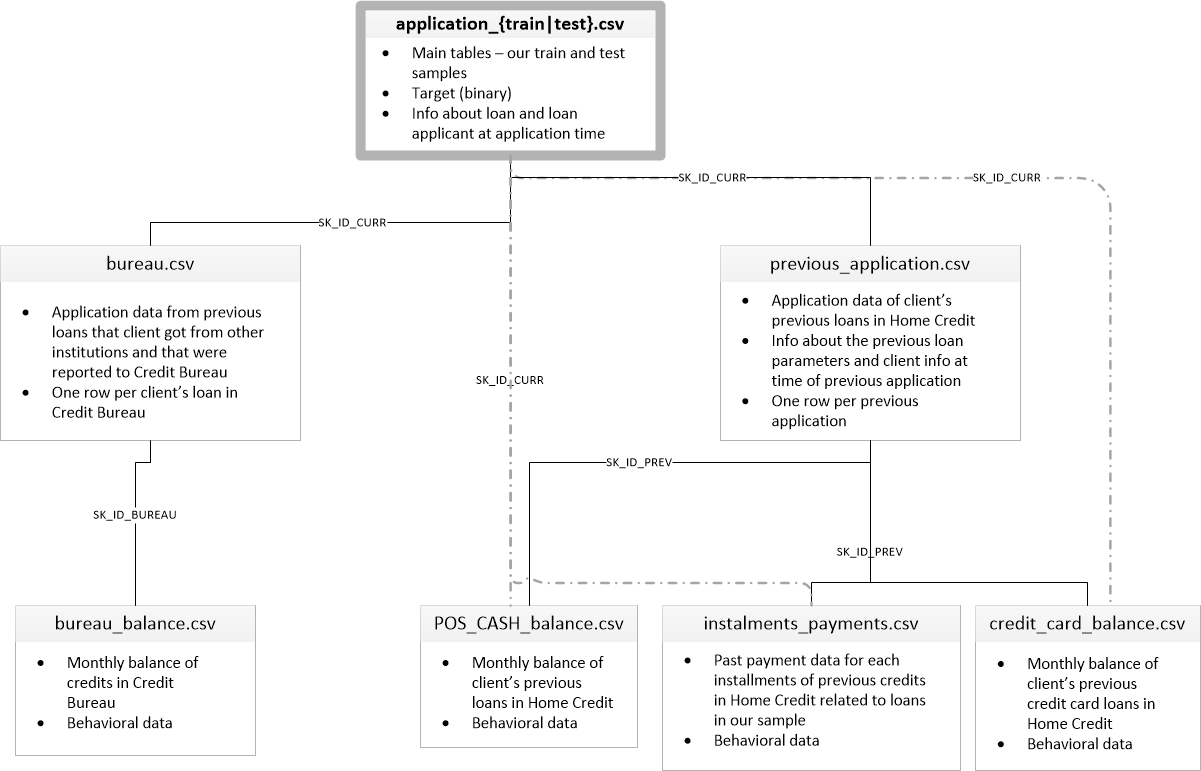


# bureau.csv


In [3]:
bureau = pd.read_csv("data/raw/bureau.csv")
display(bureau.shape)
display(bureau.head())
description_bureau, _, _, _ = compute_description(bureau, des[des.Table=='bureau.csv'].rename({'Row': 'Feature'}, axis=1))
description_bureau

(1716428, 17)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


,Table,Feature,Description,Special,dtype,TYPE,nunique,NaN count,NaN %
0,bureau.csv,SK_ID_CURR,"ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau",hashed,int64,NUMERIC,305811,0,0.00
1,bureau.csv,SK_ID_BUREAU,Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application),hashed,int64,NUMERIC,1716428,0,0.00
2,bureau.csv,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits,,object,CATEGORICAL,4,0,0.00
3,bureau.csv,CREDIT_CURRENCY,Recoded currency of the Credit Bureau credit,recoded,object,CATEGORICAL,4,0,0.00
4,bureau.csv,DAYS_CREDIT,How many days before current application did client apply for Credit Bureau credit,time only relative to the application,int64,NUMERIC,2923,0,0.00
5,bureau.csv,CREDIT_DAY_OVERDUE,Number of days past due on CB credit at the time of application for related loan in our sample,,int64,NUMERIC,942,0,0.00
6,bureau.csv,DAYS_CREDIT_ENDDATE,Remaining duration of CB credit (in days) at the time of application in Home Credit,time only relative to the application,float64,NUMERIC,14096,105553,6.15
7,bureau.csv,DAYS_ENDDATE_FACT,Days since CB credit ended at the time of application in Home Credit (only for closed credit),time only relative to the application,float64,NUMERIC,2917,633653,36.92
8,bureau.csv,AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample),,float64,NUMERIC,68251,1124488,65.51
9,bureau.csv,CNT_CREDIT_PROLONG,How many times was the Credit Bureau credit prolonged,,int64,NUMERIC,10,0,0.00


In [65]:
# number of debt type
credit_active = bureau.pivot_table(index='SK_ID_CURR', columns='CREDIT_ACTIVE', values='SK_ID_BUREAU', aggfunc='count', fill_value=0).rename(columns={
    'Active': 'NUM_ACTIVE_DEBT_TYPE',
    'Closed': 'NUM_CLOSED_DEBT_TYPE',
    'Sold': 'NUM_SOLD_DEBT_TYPE',
    'Bad debt': 'NUM_BAD_DEBT_TYPE'
})
credit_active

CREDIT_ACTIVE,NUM_ACTIVE_DEBT_TYPE,NUM_BAD_DEBT_TYPE,NUM_CLOSED_DEBT_TYPE,NUM_SOLD_DEBT_TYPE
SK_ID_CURR,,,,
100001,3,0,4,0
100002,2,0,6,0
100003,1,0,3,0
100004,0,0,2,0
100005,2,0,1,0
...,...,...,...,...
456249,2,0,11,0
456250,2,0,1,0
456253,2,0,2,0


In [66]:
display(bureau.CREDIT_CURRENCY.value_counts())
currency = bureau.pivot_table(index='SK_ID_CURR', columns='CREDIT_CURRENCY', values='SK_ID_BUREAU', aggfunc='count', fill_value=0)
currency = currency[(currency['currency 2'] + currency['currency 3'] + currency['currency 4'] > 0)]
currency['HAS_FOREIGN_CURRENCY_DEBT'] = 1

CREDIT_CURRENCY
currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: count, dtype: int64

In [75]:
display(bureau.CREDIT_TYPE.value_counts(dropna=False))
bureau['CREDIT_TYPE_SIMPLIFIED'] = bureau['CREDIT_TYPE'].replace({
    'Consumer credit' : 'Consumer credit',
    'Credit card' : 'Credit card', 
    'Car loan' : 'Auto loan',
    'Microloan' : 'Microloan',
    'Mortgage' : 'Mortgage',
    'Loan for business development' : 'Business loan',
    'Loan for purchase of shares (margin lending)' : 'Other',
    'Loan for the purchase of equipment' : 'Business loan',
    'Another type of loan' : 'Other',
    'Real estate loan' : 'Mortgage',
    'Unknown type of loan' : 'Other',
    'Mobile operator loan' : 'Other',
    'Interbank credit' : 'Other',
    'Cash loan (non-earmarked)' : 'Other',
    'Loan for working capital replenishment' : 'Business loan'
})
display(bureau.CREDIT_TYPE_SIMPLIFIED.value_counts(dropna=False))

CREDIT_TYPE
Consumer credit                                 1251615
Credit card                                      402195
Car loan                                          27690
Mortgage                                          18391
Microloan                                         12413
Loan for business development                      1975
Another type of loan                               1017
Unknown type of loan                                555
Loan for working capital replenishment              469
Cash loan (non-earmarked)                            56
Real estate loan                                     27
Loan for the purchase of equipment                   19
Loan for purchase of shares (margin lending)          4
Mobile operator loan                                  1
Interbank credit                                      1
Name: count, dtype: int64

CREDIT_TYPE_SIMPLIFIED
Consumer credit    1251615
Credit card         402195
Auto loan            27690
Mortgage             18418
Microloan            12413
Business loan         2463
Other                 1634
Name: count, dtype: int64

In [ ]:
backbone_train = backbone_train.merge(credit_active, how='left', on='SK_ID_CURR').merge(currency[['HAS_FOREIGN_CURRENCY_DEBT']], how='left', on='SK_ID_CURR').fillna(0)
backbone_test = backbone_test.merge(credit_active, how='left', on='SK_ID_CURR').merge(currency[['HAS_FOREIGN_CURRENCY_DEBT']], how='left', on='SK_ID_CURR').fillna(0)

# bureau_balance.csv


In [4]:
bureau_balance = pd.read_csv("data/raw/bureau_balance.csv")
display(bureau_balance.shape)
display(bureau_balance.head())
description_bureau_balance, _, _, _ = compute_description(bureau_balance, des[des.Table=='bureau_balance.csv'].rename({'Row': 'Feature'}, axis=1))
description_bureau_balance

(27299925, 3)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


,Table,Feature,Description,Special,dtype,TYPE,nunique,NaN count,NaN %
0,bureau_balance.csv,SK_ID_BUREAU,Recoded ID of Credit Bureau credit (unique coding for each application) - use this to join to CREDIT_BUREAU table,hashed,int64,NUMERIC,817395,0,0.0
1,bureau_balance.csv,MONTHS_BALANCE,Month of balance relative to application date (-1 means the freshest balance date),time only relative to the application,int64,NUMERIC,97,0,0.0
2,bureau_balance.csv,STATUS,"Status of Credit Bureau loan during the month (active, closed, DPD0-30,ï¿½ [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,ï¿½ 5 means DPD 120+ or sold or written off ] )",,object,CATEGORICAL,8,0,0.0


# previous_application.csv


In [5]:
previous_application = pd.read_csv("data/raw/previous_application.csv")
display(previous_application.shape)
display(previous_application.head())
description_previous_application, _, _, _ = compute_description(previous_application, des[des.Table=='previous_application.csv'].rename({'Row': 'Feature'}, axis=1))
description_previous_application

(1670214, 37)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


,Table,Feature,Description,Special,dtype,TYPE,nunique,NaN count,NaN %
0,previous_application.csv,SK_ID_CURR,ID of loan in our sample,hashed,int64,NUMERIC,338857,0,0.00
1,previous_application.csv,NAME_CONTRACT_TYPE,"Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application",,object,CATEGORICAL,4,0,0.00
2,previous_application.csv,AMT_ANNUITY,Annuity of previous application,,float64,NUMERIC,357959,372235,22.29
3,previous_application.csv,AMT_APPLICATION,For how much credit did client ask on the previous application,,float64,NUMERIC,93885,0,0.00
4,previous_application.csv,AMT_CREDIT,"Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT",,float64,NUMERIC,86803,1,0.00
5,previous_application.csv,AMT_DOWN_PAYMENT,Down payment on the previous application,,float64,NUMERIC,29278,895844,53.64
6,previous_application.csv,AMT_GOODS_PRICE,Goods price of good that client asked for (if applicable) on the previous application,,float64,NUMERIC,93885,385515,23.08
7,previous_application.csv,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply for previous application,,object,CATEGORICAL,7,0,0.00
8,previous_application.csv,HOUR_APPR_PROCESS_START,Approximately at what day hour did the client apply for the previous application,rounded,int64,NUMERIC,24,0,0.00
9,previous_application.csv,FLAG_LAST_APPL_PER_CONTRACT,Flag if it was last application for the previous contract. Sometimes by mistake of client or our clerk there could be more applications for one single contract,,object,CATEGORICAL,2,0,0.00


# POS_CASH_balance.csv


In [7]:
POS_CASH_balance = pd.read_csv("data/raw/POS_CASH_balance.csv")
display(POS_CASH_balance.shape)
display(POS_CASH_balance.head())
description_POS_CASH_balance, _, _, _ = compute_description(POS_CASH_balance, des[des.Table=='POS_CASH_balance.csv'].rename({'Row': 'Feature'}, axis=1))
description_POS_CASH_balance

(10001358, 8)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


,Table,Feature,Description,Special,dtype,TYPE,nunique,NaN count,NaN %
0,POS_CASH_balance.csv,SK_ID_CURR,ID of loan in our sample,,int64,NUMERIC,337252,0,0.00
1,POS_CASH_balance.csv,MONTHS_BALANCE,"Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )",time only relative to the application,int64,NUMERIC,96,0,0.00
2,POS_CASH_balance.csv,CNT_INSTALMENT,Term of previous credit (can change over time),,float64,NUMERIC,73,26071,0.26
3,POS_CASH_balance.csv,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit,,float64,NUMERIC,79,26087,0.26
4,POS_CASH_balance.csv,NAME_CONTRACT_STATUS,Contract status during the month,,object,CATEGORICAL,9,0,0.00
5,POS_CASH_balance.csv,SK_DPD,DPD (days past due) during the month of previous credit,,int64,NUMERIC,3400,0,0.00
6,POS_CASH_balance.csv,SK_DPD_DEF,DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit,,int64,NUMERIC,2307,0,0.00


# credit_card_balance.csv


In [9]:
credit_card_balance = pd.read_csv("data/raw/credit_card_balance.csv")
display(credit_card_balance.shape)
display(credit_card_balance.head())
description_credit_card_balance, _, _, _ = compute_description(credit_card_balance, des[des.Table=='credit_card_balance.csv'].rename({'Row': 'Feature'}, axis=1))
description_credit_card_balance

(3840312, 23)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


,Table,Feature,Description,Special,dtype,TYPE,nunique,NaN count,NaN %
0,credit_card_balance.csv,SK_ID_CURR,ID of loan in our sample,hashed,int64,NUMERIC,103558,0,0.00
1,credit_card_balance.csv,MONTHS_BALANCE,Month of balance relative to application date (-1 means the freshest balance date),time only relative to the application,int64,NUMERIC,96,0,0.00
2,credit_card_balance.csv,AMT_BALANCE,Balance during the month of previous credit,,float64,NUMERIC,1347904,0,0.00
3,credit_card_balance.csv,AMT_CREDIT_LIMIT_ACTUAL,Credit card limit during the month of the previous credit,,int64,NUMERIC,181,0,0.00
4,credit_card_balance.csv,AMT_DRAWINGS_ATM_CURRENT,Amount drawing at ATM during the month of the previous credit,,float64,NUMERIC,2267,749816,19.52
5,credit_card_balance.csv,AMT_DRAWINGS_CURRENT,Amount drawing during the month of the previous credit,,float64,NUMERIC,187005,0,0.00
6,credit_card_balance.csv,AMT_DRAWINGS_OTHER_CURRENT,Amount of other drawings during the month of the previous credit,,float64,NUMERIC,1832,749816,19.52
7,credit_card_balance.csv,AMT_DRAWINGS_POS_CURRENT,Amount drawing or buying goods during the month of the previous credit,,float64,NUMERIC,168748,749816,19.52
8,credit_card_balance.csv,AMT_INST_MIN_REGULARITY,Minimal installment for this month of the previous credit,,float64,NUMERIC,312266,305236,7.95
9,credit_card_balance.csv,AMT_PAYMENT_CURRENT,How much did the client pay during the month on the previous credit,,float64,NUMERIC,163209,767988,20.00


# installments_payments.csv


In [8]:
installments_payments = pd.read_csv("data/raw/installments_payments.csv")
display(installments_payments.shape)
display(installments_payments.head())
description_installments_payments, _, _, _ = compute_description(installments_payments, des[des.Table=='installments_payments.csv'].rename({'Row': 'Feature'}, axis=1))
description_installments_payments

(13605401, 8)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


,Table,Feature,Description,Special,dtype,TYPE,nunique,NaN count,NaN %
0,installments_payments.csv,SK_ID_CURR,ID of loan in our sample,hashed,int64,NUMERIC,339587,0,0.00
1,installments_payments.csv,NUM_INSTALMENT_VERSION,Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed,,float64,NUMERIC,65,0,0.00
2,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,,int64,NUMERIC,277,0,0.00
3,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was supposed to be paid (relative to application date of current loan),time only relative to the application,float64,NUMERIC,2922,0,0.00
4,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit paid actually (relative to application date of current loan),time only relative to the application,float64,NUMERIC,3039,2905,0.02
5,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of previous credit on this installment,,float64,NUMERIC,902539,0,0.00
6,installments_payments.csv,AMT_PAYMENT,What the client actually paid on previous credit on this installment,,float64,NUMERIC,944235,2905,0.02
